## Importing the required packages/libraries

In [254]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

## Exploratory Data Analysis

In [255]:
coupon_df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
coupon_df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [256]:
coupon_df.shape

(12684, 26)

In [257]:
coupon_df.isna().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [258]:
percent_missing =coupon_df.isnull().sum() * 100 / len(coupon_df)
percent_missing

destination              0.000000
passanger                0.000000
weather                  0.000000
temperature              0.000000
time                     0.000000
coupon                   0.000000
expiration               0.000000
gender                   0.000000
age                      0.000000
maritalStatus            0.000000
has_children             0.000000
education                0.000000
occupation               0.000000
income                   0.000000
car                     99.148534
Bar                      0.843582
CoffeeHouse              1.710817
CarryAway                1.190476
RestaurantLessThan20     1.024913
Restaurant20To50         1.490066
toCoupon_GEQ5min         0.000000
toCoupon_GEQ15min        0.000000
toCoupon_GEQ25min        0.000000
direction_same           0.000000
direction_opp            0.000000
Y                        0.000000
dtype: float64

As car, Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50 has many missing values. So this data needs to be cleaned for these columns. Columns in data with more than 95% null are dropped. 

In [259]:
list(percent_missing[percent_missing > 95].index)

['car']

In [260]:
coupon_df.drop(columns=list(percent_missing[percent_missing > 95].index), inplace=True)

In [261]:
coupon_df.shape

(12684, 25)

In [262]:
lst = list(percent_missing[(percent_missing > 0) & (percent_missing < 95)].index)
for i in lst:
    print(coupon_df[str(i)].value_counts())

never    5197
less1    3482
1~3      2473
4~8      1076
gt8       349
Name: Bar, dtype: int64
less1    3385
1~3      3225
never    2962
4~8      1784
gt8      1111
Name: CoffeeHouse, dtype: int64
1~3      4672
4~8      4258
less1    1856
gt8      1594
never     153
Name: CarryAway, dtype: int64
1~3      5376
4~8      3580
less1    2093
gt8      1285
never     220
Name: RestaurantLessThan20, dtype: int64
less1    6077
1~3      3290
never    2136
4~8       728
gt8       264
Name: Restaurant20To50, dtype: int64


In [263]:
coupon_df['Bar'] = coupon_df['Bar'].fillna(coupon_df['Bar'].value_counts().index[0])
coupon_df.Bar.isna().sum()

0

In [264]:
coupon_df['CoffeeHouse'] = coupon_df['CoffeeHouse'].fillna(coupon_df['CoffeeHouse'].value_counts().index[0])
coupon_df.CoffeeHouse.isna().sum()

0

In [265]:
for i in lst:
    coupon_df[i] = coupon_df[i].fillna(coupon_df[i].value_counts().index[0])
    print(coupon_df[i].isna().sum())

0
0
0
0
0


In [266]:
part_70 = coupon_df.sample(frac = 0.7)
test_df = coupon_df.drop(part_70.index)
print(test_df.shape, part_70.shape)


(3805, 25) (8879, 25)


In [267]:
validation_df = part_70.sample(frac = 0.3)
train_df = part_70.drop(validation_df.index)
train_df_wo_encoding=train_df 
validation_df_wo_encoding= validation_df
print(train_df.shape, validation_df.shape)

(6215, 25) (2664, 25)


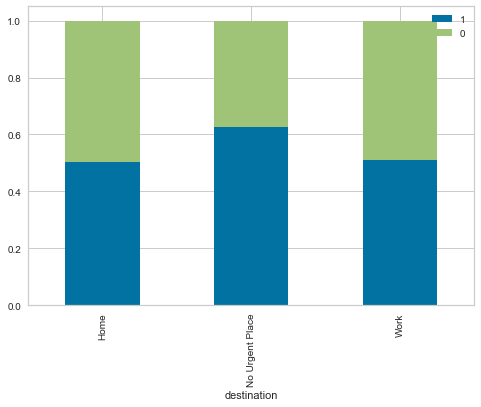

In [268]:
ax1 = train_df.groupby(['destination'])['Y'].apply(lambda x: x.value_counts() / len(x)).transpose().unstack().plot(kind='bar',stacked = True)

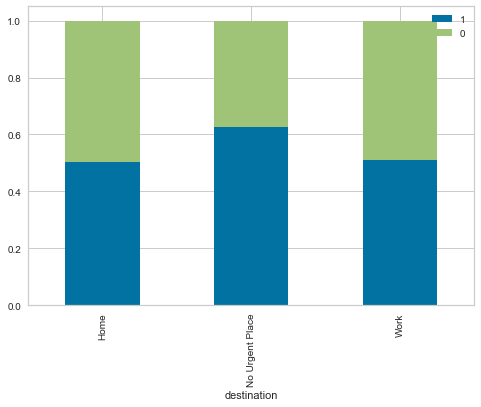

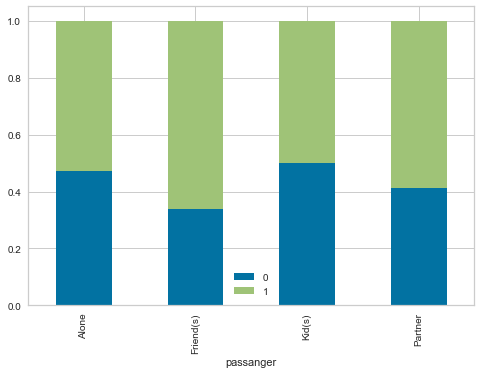

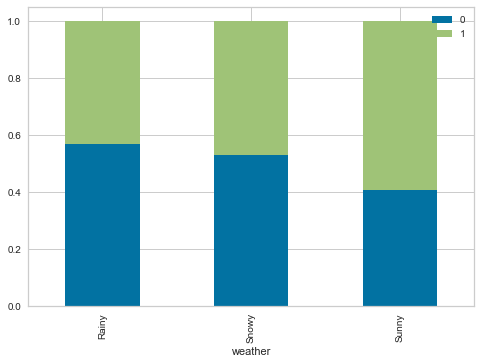

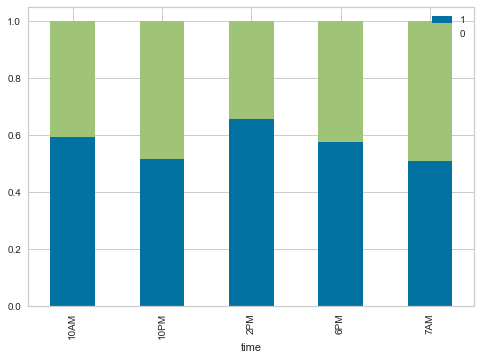

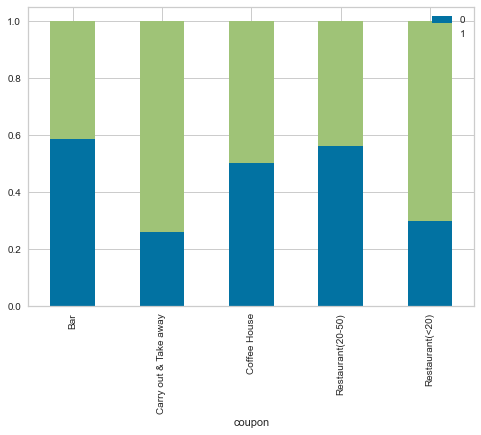

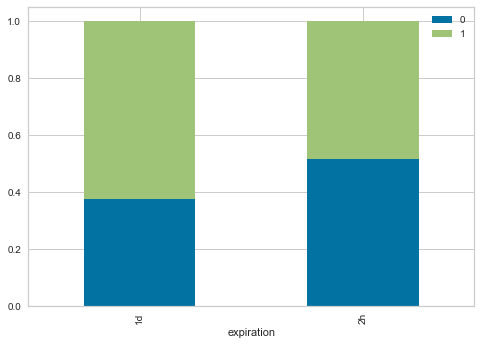

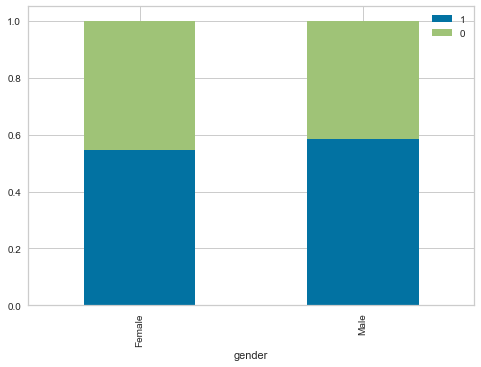

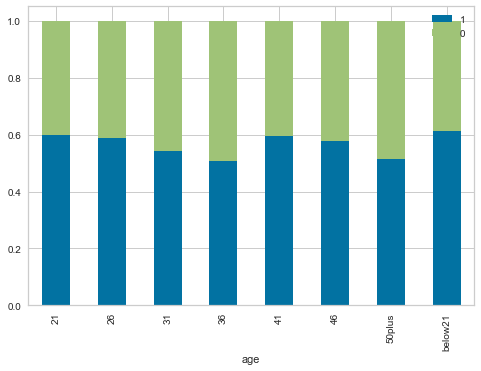

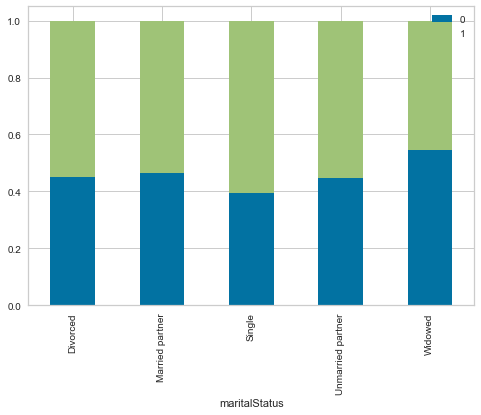

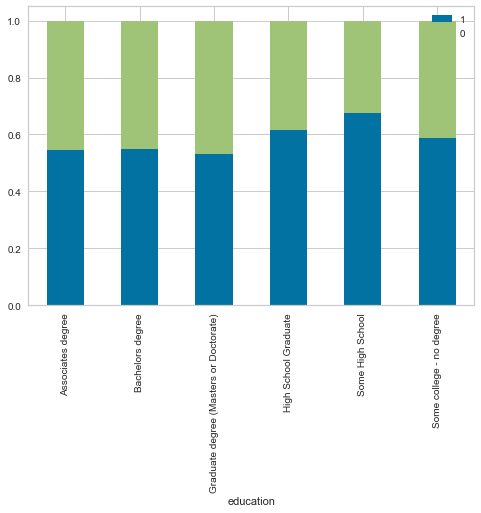

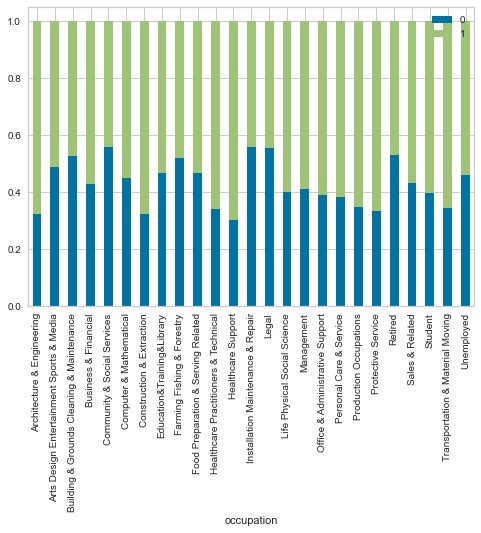

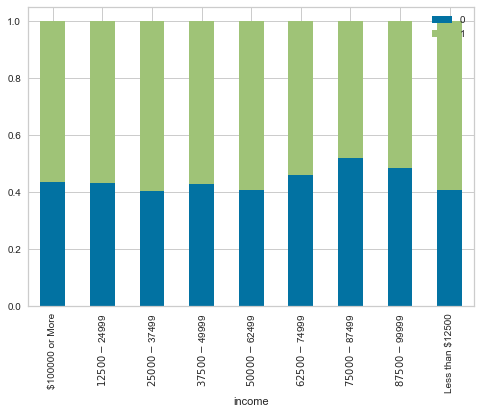

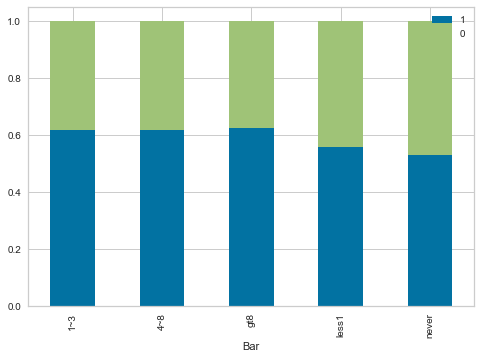

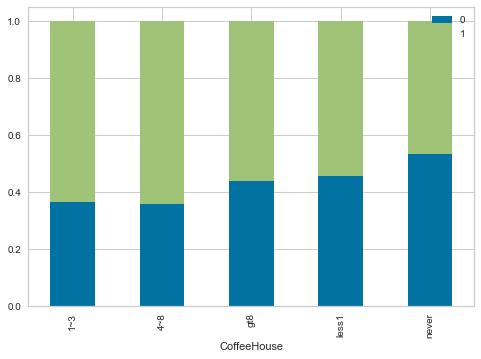

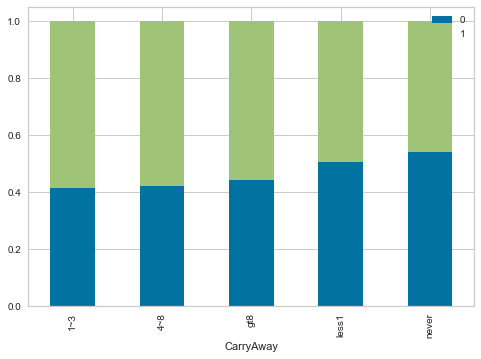

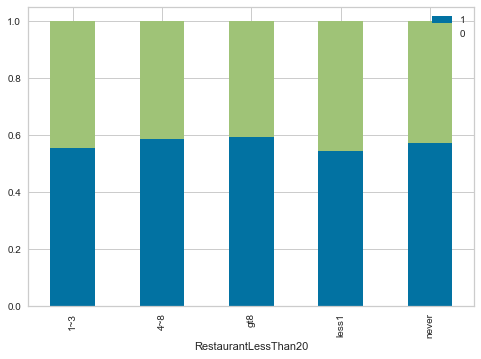

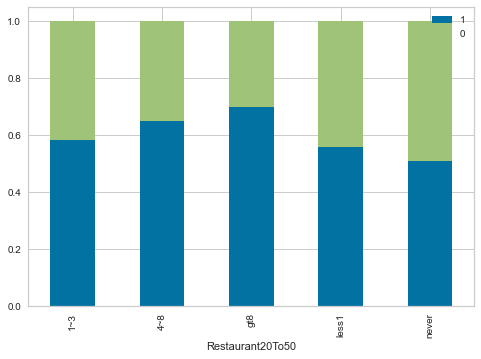

In [269]:
categorical_data = train_df.select_dtypes(exclude=[np.number])
cat_list = list(categorical_data.columns)
numeric_data = train_df.select_dtypes(include=[np.number])
num_list = list(numeric_data.columns)

for i in cat_list:
    train_df.groupby([i])['Y'].apply(lambda x: x.value_counts() / len(x)).transpose().unstack().plot(kind='bar',stacked = True)


In [270]:
print(cat_list)

['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']


In [271]:
train_df['RestaurantLessThan20'] = train_df['RestaurantLessThan20'].replace(['1~3','4~8'],'1~8')
train_df['RestaurantLessThan20'].value_counts()

1~8      4422
less1    1052
gt8       641
never     100
Name: RestaurantLessThan20, dtype: int64

In [272]:
validation_df['RestaurantLessThan20'] = validation_df['RestaurantLessThan20'].replace(['1~3','4~8'],'1~8')

In [273]:
train_df['CarryAway'] = train_df['CarryAway'].replace(['1~3','4~8', 'gt8'],'1~8ngt8')
train_df['CarryAway'] = train_df['CarryAway'].replace(['less1','never'],'less1_never')
train_df['CarryAway'].value_counts()

1~8ngt8        5252
less1_never     963
Name: CarryAway, dtype: int64

In [274]:
validation_df['CarryAway'] = validation_df['CarryAway'].replace(['1~3','4~8', 'gt8'],'1~8ngt8')
validation_df['CarryAway'] = validation_df['CarryAway'].replace(['less1','never'],'less1_never')

In [275]:
train_df['CoffeeHouse'] = train_df['CoffeeHouse'].replace(['1~3','4~8', 'gt8'],'1~8ngt8')
train_df['CoffeeHouse'].value_counts()

1~8ngt8    3027
less1      1747
never      1441
Name: CoffeeHouse, dtype: int64

In [276]:
validation_df['CoffeeHouse'] = validation_df['CoffeeHouse'].replace(['1~3','4~8', 'gt8'],'1~8ngt8')

In [277]:
train_df['Bar'] = train_df['Bar'].replace(['1~3','4~8'],'1~8')
train_df['Bar'].value_counts()

never    2618
1~8      1747
less1    1677
gt8       173
Name: Bar, dtype: int64

In [278]:
validation_df['Bar'] = validation_df['Bar'].replace(['1~3','4~8'],'1~8')

In [279]:
train_df['income'] = train_df['income'].replace(['$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499'],'$12500-$62499')
train_df['income'] = train_df['income'].replace(['$75000 - $87499','$87500 - $99999','$62500 - $74999'],'$62499-$99999')
train_df['income'].value_counts()


$12500-$62499       3548
$62499-$99999       1332
$100000 or More      841
Less than $12500     494
Name: income, dtype: int64

In [280]:
validation_df['income'] = validation_df['income'].replace(['$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499'],'$12500-$62499')
validation_df['income'] = validation_df['income'].replace(['$75000 - $87499','$87500 - $99999','$62500 - $74999'],'$62499-$99999')

<AxesSubplot:xlabel='occupation'>

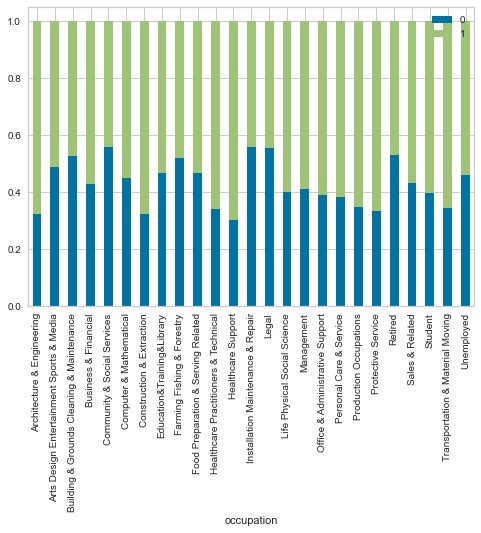

In [281]:
train_df.groupby(['occupation'])['Y'].apply(lambda x: x.value_counts() / len(x)).transpose().unstack().plot(kind='bar',stacked = True)

In [282]:
l = ['Architecture & Engineering', 'Construction & Extraction','Healthcare Support','Food Preparation & Serving Related','Healthcare Practitioners & Technical', 'Farming Fishing & Forestry']
train_df['occupation'] = train_df['occupation'].replace(l,'Arch_cons_Health_Food_Farm')
train_df['occupation'] = train_df['occupation'].replace(['Business & Financial', 'Education&Training&Library', 'Retired'],'Buss_Edu_Retired')
train_df['occupation'] = train_df['occupation'].replace(['Arts Design Entertainment Sports & Media', 'Community & Social Services', 'Building & Grounds Cleaning & Maintenance'],'Arts_Comm_Building')
train_df['occupation'] = train_df['occupation'].replace(['Computer & Mathematical', 'Installation Maintenance & Repair', 'Personal Care & Service', 'Sales & Related', 'Unemployed'],'comp_Inst_Pers_Sales_Unemployed')
train_df['occupation'] = train_df['occupation'].replace(['Student', 'Management', 'Office & Administrative Support', 'Transportation & Material Moving', 'Protective Service','Life Physical Social Science', 'Production Occupations'],'Stud_manage_off_Trans_Protect_Life_Prod')
train_df['occupation'].value_counts()

comp_Inst_Pers_Sales_Unemployed            2278
Stud_manage_off_Trans_Protect_Life_Prod    1820
Buss_Edu_Retired                           1017
Arch_cons_Health_Food_Farm                  548
Arts_Comm_Building                          453
Legal                                        99
Name: occupation, dtype: int64

In [283]:
l = ['Architecture & Engineering', 'Construction & Extraction','Healthcare Support','Food Preparation & Serving Related','Healthcare Practitioners & Technical', 'Farming Fishing & Forestry']
validation_df['occupation'] = validation_df['occupation'].replace(l,'Arch_cons_Health_Food_Farm')
validation_df['occupation'] = validation_df['occupation'].replace(['Business & Financial', 'Education&Training&Library', 'Retired'],'Buss_Edu_Retired')
validation_df['occupation'] = validation_df['occupation'].replace(['Arts Design Entertainment Sports & Media', 'Community & Social Services', 'Building & Grounds Cleaning & Maintenance'],'Arts_Comm_Building')
validation_df['occupation'] = validation_df['occupation'].replace(['Computer & Mathematical', 'Installation Maintenance & Repair', 'Personal Care & Service', 'Sales & Related', 'Unemployed'],'comp_Inst_Pers_Sales_Unemployed')
validation_df['occupation'] = validation_df['occupation'].replace(['Student', 'Management', 'Office & Administrative Support', 'Transportation & Material Moving', 'Protective Service','Life Physical Social Science', 'Production Occupations'],'Stud_manage_off_Trans_Protect_Life_Prod')

In [284]:
train_df['education'] = train_df['education'].replace(['Bachelors degree','Associates degree', 'Graduate degree (Masters or Doctorate)'],'Bach_Mast_Asso')
train_df['education'] = train_df['education'].replace(['Some college - no degree','High School Graduate'],'Nodeg_HSGrad')
train_df['education'].value_counts()

Bach_Mast_Asso      3629
Nodeg_HSGrad        2549
Some High School      37
Name: education, dtype: int64

In [285]:
validation_df['education'] = validation_df['education'].replace(['Bachelors degree','Associates degree', 'Graduate degree (Masters or Doctorate)'],'Bach_Mast_Asso')
validation_df['education'] = validation_df['education'].replace(['Some college - no degree','High School Graduate'],'Nodeg_HSGrad')

In [286]:
train_df['maritalStatus'] = train_df['maritalStatus'].replace(['Married partner', 'Divorced', 'Widowed'],'Married_Divorced_Widowed')
train_df['maritalStatus'] = train_df['maritalStatus'].replace(['Single', 'Unmarried partner'],'Single_Unmarriedpartner')
train_df['maritalStatus'].value_counts()

Single_Unmarriedpartner     3386
Married_Divorced_Widowed    2829
Name: maritalStatus, dtype: int64

In [287]:
validation_df['maritalStatus'] = validation_df['maritalStatus'].replace(['Married partner', 'Divorced', 'Widowed'],'Married_Divorced_Widowed')
validation_df['maritalStatus'] = validation_df['maritalStatus'].replace(['Single', 'Unmarried partner'],'Single_Unmarriedpartner')

In [288]:
train_df['age'] = train_df['age'].replace(['26','21', 'below21'],'below26')
train_df['age'] = train_df['age'].replace(['31','50plus', '36','41', '46'],'above26')
train_df['age'].value_counts()

above26    3404
below26    2811
Name: age, dtype: int64

In [289]:
validation_df['age'] = validation_df['age'].replace(['26','21', 'below21'],'below26')
validation_df['age'] = validation_df['age'].replace(['31','50plus', '36','41', '46'],'above26')

In [290]:
train_df['coupon'] = train_df['coupon'].replace(['Restaurant(20-50)','Bar'],'Rest(20-50)_n_Bar')
train_df['coupon'] = train_df['coupon'].replace(['Restaurant(<20)','Coffee House','Carry out & Take away'],'Rest(<20)_CH_CT')
train_df['coupon'].value_counts()

Rest(<20)_CH_CT      4452
Rest(20-50)_n_Bar    1763
Name: coupon, dtype: int64

In [291]:
validation_df['coupon'] = validation_df['coupon'].replace(['Restaurant(20-50)','Bar'],'Rest(20-50)_n_Bar')
validation_df['coupon'] = validation_df['coupon'].replace(['Restaurant(<20)','Coffee House','Carry out & Take away'],'Rest(<20)_CH_CT')

In [292]:
train_df['destination'] = train_df['destination'].replace(['Home','Work'],'Home_n_Work')
train_df['destination'].value_counts()


Home_n_Work        3179
No Urgent Place    3036
Name: destination, dtype: int64

In [293]:
validation_df['destination'] = validation_df['destination'].replace(['Home','Work'],'Home_n_Work')

In [294]:
train_df['passanger'] = train_df['passanger'].replace(['Alone','Kid(s)'],'Alone_n_Kids')
train_df['passanger'].value_counts()

Alone_n_Kids    4094
Friend(s)       1599
Partner          522
Name: passanger, dtype: int64

In [295]:
validation_df['passanger'] = validation_df['passanger'].replace(['Alone','Kid(s)'],'Alone_n_Kids')

In [296]:
train_df['weather'] = train_df['weather'].replace(['Snowy','Rainy'],'Snowy_n_Rainy')
train_df['weather'].value_counts()

Sunny            4951
Snowy_n_Rainy    1264
Name: weather, dtype: int64

In [297]:
validation_df['weather'] = validation_df['weather'].replace(['Snowy','Rainy'],'Snowy_n_Rainy')

In [298]:
train_df['time'] = train_df['time'].replace(['7AM','10PM'],'7AM_n_10PM')
train_df['time'] = train_df['time'].replace(['6PM','10AM', '2PM'],'6PM_10AM_2PM')
train_df['time'].value_counts()

6PM_10AM_2PM    3666
7AM_n_10PM      2549
Name: time, dtype: int64

In [299]:
validation_df['time'] = validation_df['time'].replace(['7AM','10PM'],'7AM_n_10PM')
validation_df['time'] = validation_df['time'].replace(['6PM','10AM', '2PM'],'6PM_10AM_2PM')

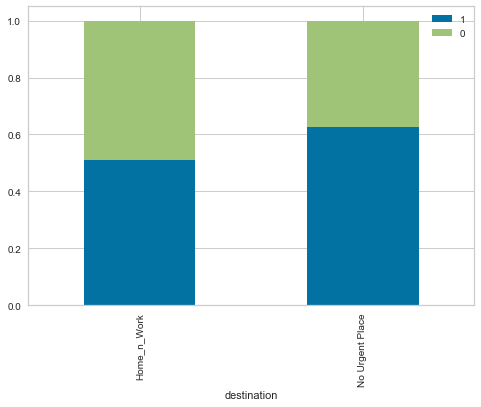

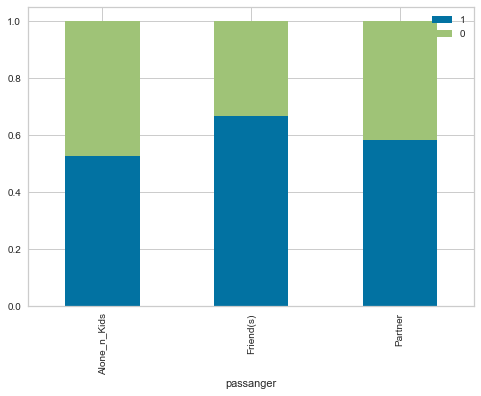

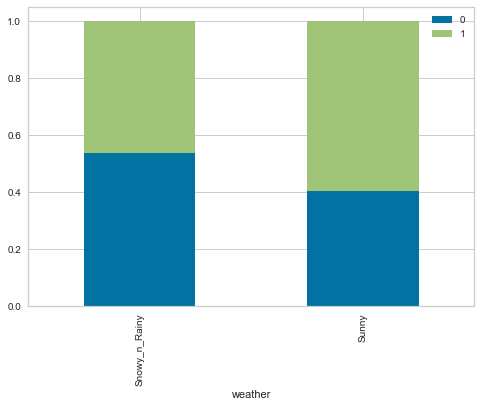

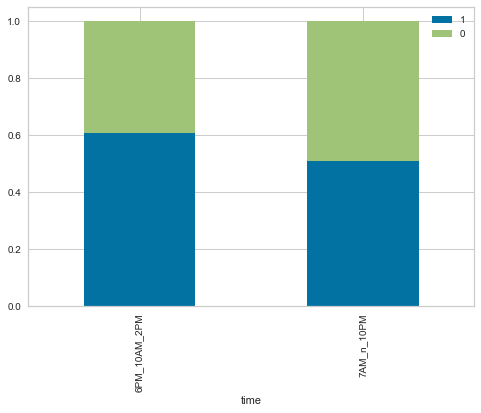

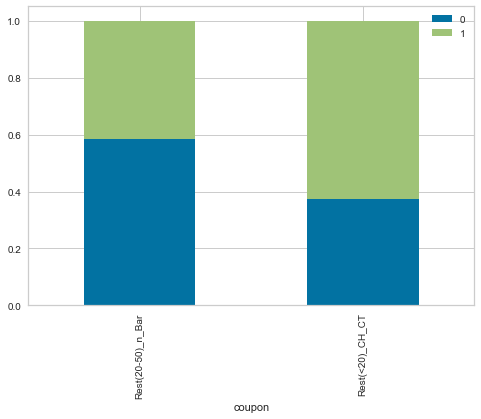

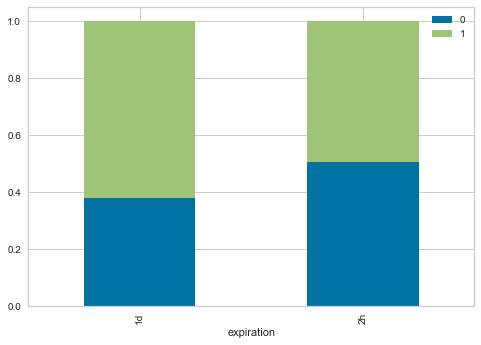

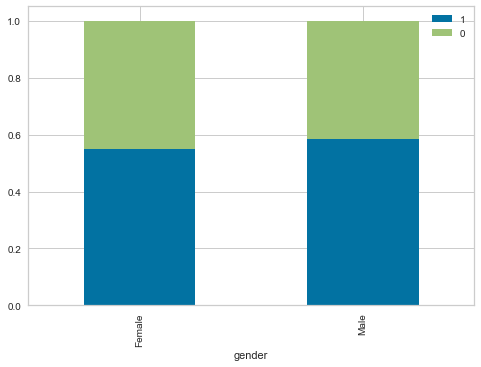

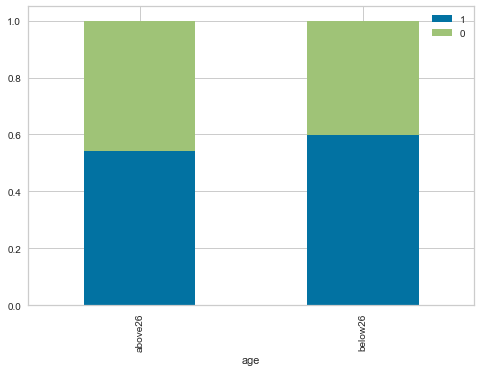

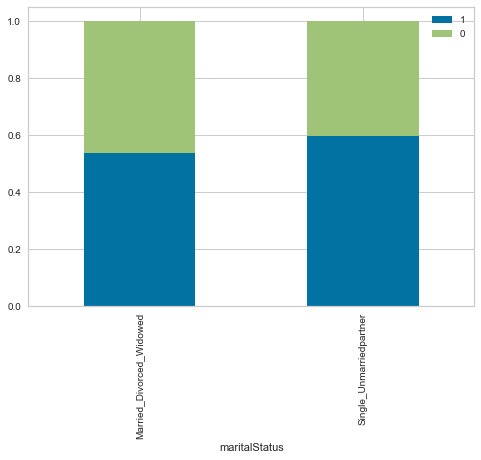

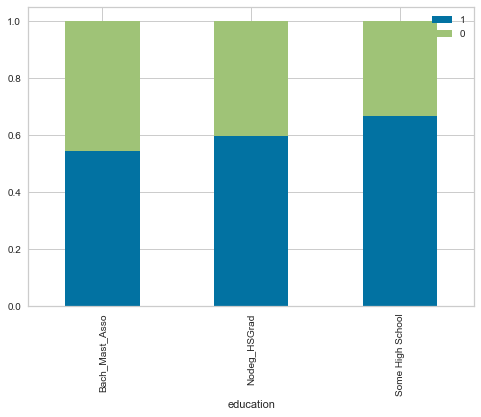

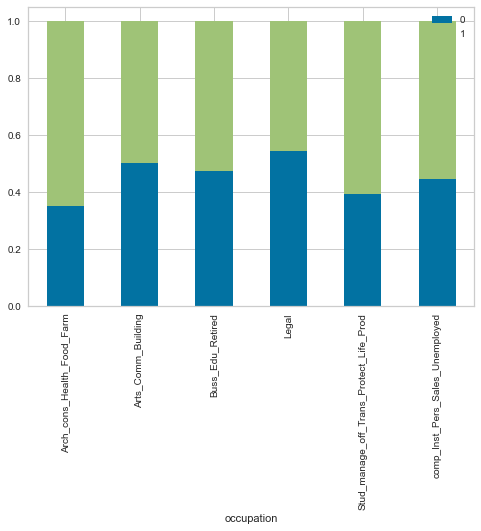

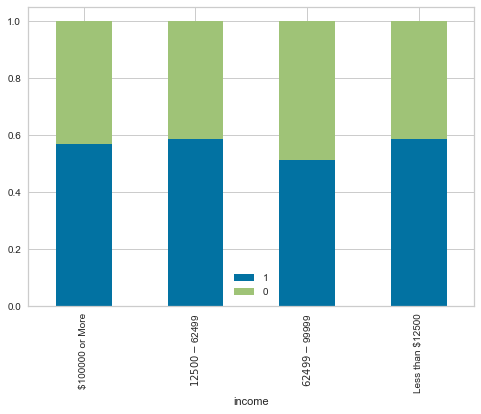

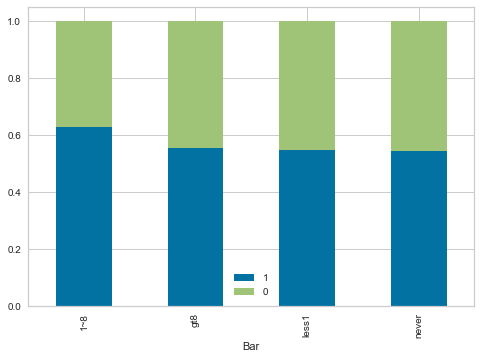

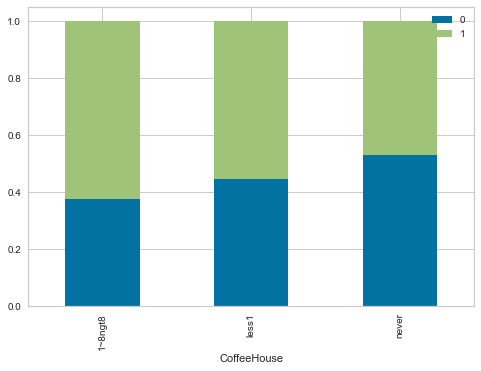

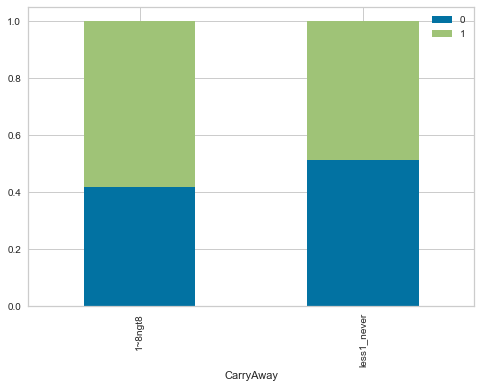

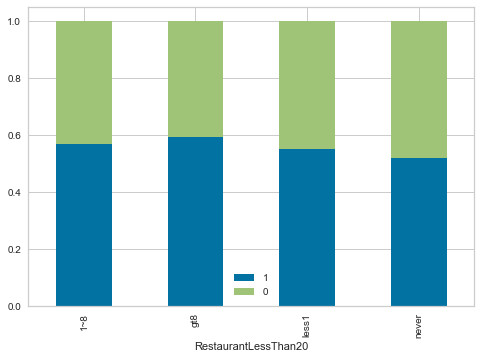

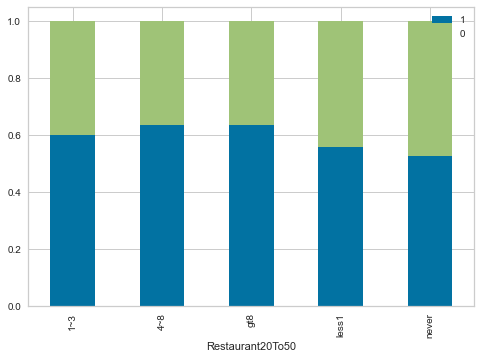

In [180]:
for i in cat_list:
    train_df.groupby([i])['Y'].apply(lambda x: x.value_counts() / len(x)).transpose().unstack().plot(kind='bar',stacked = True)

In [181]:
train_df['occupation'] = train_df['occupation'].replace(['Arts_Comm_Building','Buss_Edu_Retired'],'Arts_Comm_Building_Buss_Edu_Retired')

In [182]:
validation_df['occupation'] = validation_df['occupation'].replace(['Arts_Comm_Building','Buss_Edu_Retired'],'Arts_Comm_Building_Buss_Edu_Retired')

In [183]:
train_df['CoffeeHouse'].value_counts()

1~8ngt8    3004
less1      1767
never      1444
Name: CoffeeHouse, dtype: int64

In [184]:
train_df.groupby(['Restaurant20To50'])['Y'].apply(lambda x: x.value_counts() / len(x))

Restaurant20To50   
1~3               1    0.598275
                  0    0.401725
4~8               1    0.633333
                  0    0.366667
gt8               1    0.633929
                  0    0.366071
less1             1    0.556134
                  0    0.443866
never             1    0.525310
                  0    0.474690
Name: Y, dtype: float64

In [185]:
cat_list

['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'occupation',
 'income',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50']

In [186]:
cleanup_nums = {"destination": {"No Urgent Place": 2,"Home_n_Work": 1 },
                "passanger":   {"Alone_n_Kids": 3, "Partner": 2, "Friend(s)": 1},
                "weather": {"Sunny": 2,"Snowy_n_Rainy": 1},
                "time": {"6PM_10AM_2PM": 2,"7AM_n_10PM": 1},
                "coupon": {"Rest(<20)_CH_CT": 2,"Rest(20-50)_n_Bar": 1},
                "expiration": {"1d": 2,"2h": 1},
                "gender": {"Male": 2,"Female": 1},
                "age": {"below26": 2,"above26": 1},
                "maritalStatus": {"Single_Unmarriedpartner": 2,"Married_Divorced_Widowed": 1},
                "education": {"Some High School": 3,"Nodeg_HSGrad": 2, "Bach_Mast_Asso": 1 },
                "occupation": {"Arch_cons_Health_Food_Farm": 5,"Stud_manage_off_Trans_Protect_Life_Prod": 4,"comp_Inst_Pers_Sales_Unemployed": 3, "Arts_Comm_Building_Buss_Edu_Retired": 2, "Legal": 1 },
                "income": {"Less than $12500": 4,"$12500-$62499": 3,"$100000 or More": 2, "$62499-$99999": 2},
                "car": {"Car that is too old _n_Mazda5": 4,"Scooter and motorcycle": 3, "do not drive": 2, "crossover": 1 },
                "Bar": {"1~8": 4,"less1": 3, "gt8": 2, "never": 1 },
                "CoffeeHouse": {"1~8ngt8": 3, "less1": 2, "never": 1 },
                "CarryAway": {"1~8ngt8": 2, "less1_never": 1 },
                "RestaurantLessThan20": {"gt8": 4,"1~8": 3, "never": 2, "less1": 1 },
                "Restaurant20To50": {"gt8": 5, "4~8": 4,"1~3": 3, "less1": 2, "never": 1 }
                }
train_df = train_df.replace(cleanup_nums)

In [187]:
validation_df = validation_df.replace(cleanup_nums)

In [188]:
train_df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
4341,1,3,2,80,1,2,2,1,1,2,...,2,2,3,2,1,0,0,1,0,1
367,2,1,2,80,2,2,1,1,1,1,...,2,2,3,2,1,1,0,0,1,0
790,2,1,2,80,2,2,1,1,1,1,...,2,2,1,1,1,1,0,0,1,1
5878,2,3,2,80,2,2,2,2,1,1,...,1,2,4,4,1,1,0,0,1,0
7821,2,1,2,55,2,2,2,2,2,2,...,3,2,1,2,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4332,2,2,2,80,2,2,2,1,1,2,...,2,2,3,2,1,0,0,0,1,1
4702,2,1,2,80,2,2,2,1,2,2,...,1,2,3,3,1,1,0,0,1,1
11114,1,3,1,30,1,2,1,2,2,2,...,3,2,3,1,1,1,0,0,1,1
236,1,3,2,55,1,2,1,1,2,2,...,3,2,3,3,1,1,0,0,1,0


In [189]:
num_list


['temperature',
 'has_children',
 'toCoupon_GEQ5min',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same',
 'direction_opp',
 'Y']

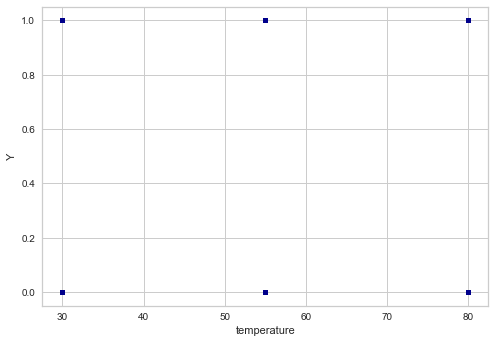

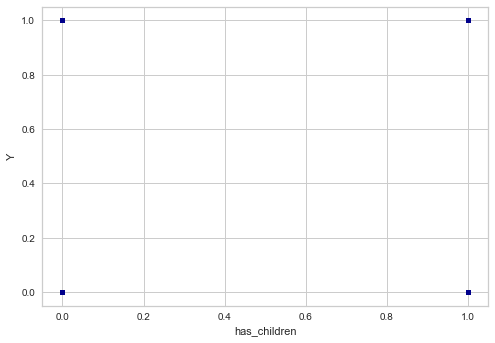

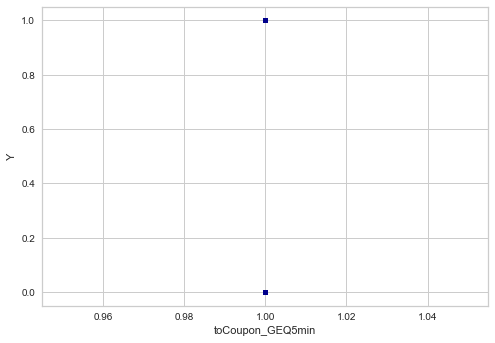

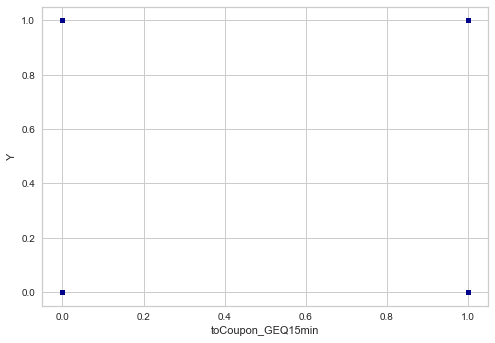

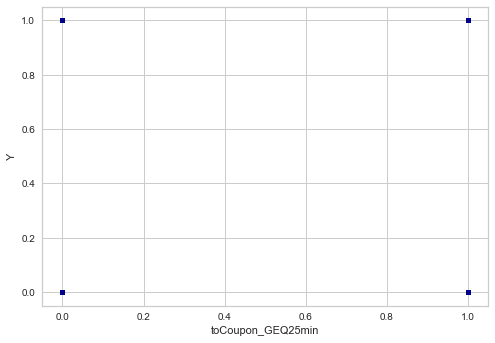

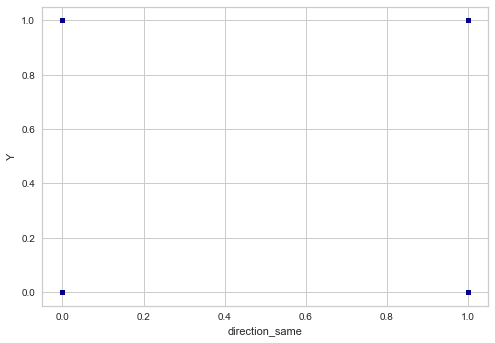

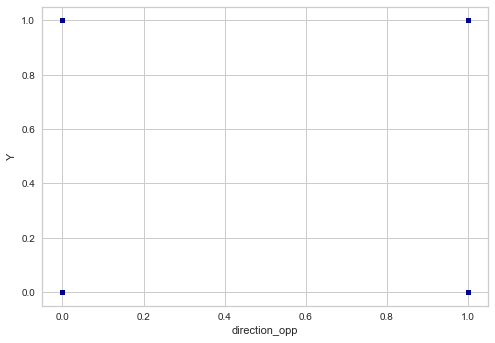

In [190]:
num_list_new = num_list[0:7]
for i in num_list_new:
    ax1 =train_df.plot.scatter(x=i, y='Y',c='DarkBlue')

In [191]:
my_r = train_df.corr(method="spearman")['Y']
print(my_r)

destination             0.117807
passanger              -0.121909
weather                 0.110288
temperature             0.066857
time                    0.097571
coupon                  0.193718
expiration              0.127692
gender                  0.034754
age                     0.055382
maritalStatus           0.059107
has_children           -0.045415
education               0.052147
occupation              0.086153
income                  0.045748
Bar                     0.064907
CoffeeHouse             0.122672
CarryAway               0.068338
RestaurantLessThan20    0.022909
Restaurant20To50        0.061230
toCoupon_GEQ5min             NaN
toCoupon_GEQ15min      -0.088079
toCoupon_GEQ25min      -0.095024
direction_same          0.013860
direction_opp          -0.013860
Y                       1.000000
Name: Y, dtype: float64


In [192]:
cat_list

['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'occupation',
 'income',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50']

In [193]:
from sklearn.feature_selection import chi2
import numpy as np
for i in train_df.columns:
    X = np.array(train_df[i]).reshape(-1,1)
    y = train_df['Y']
    chi_scores = chi2(X,y)
    #print(chi_scores[0][0])
    print(chi_scores[1][0])
    
#for i in chisq:
    #print(i[0])
    


0.00014952081781220749
3.649208012319766e-08
0.007586250190624069
4.092201357464118e-34
0.0027514448152809816
1.5776883883493563e-07
6.205150511293678e-05
0.26133730239480857
0.07140416889901227
0.06181827692574898
0.006395347883619125
0.07530435678440234
0.0002831215788760078
0.21493163899754153
7.086755672638572e-05
1.440371873255952e-07
0.15219137358391566
0.39785287639070754
0.005432860322177932
0.9999999999999939
4.35548744214483e-06
2.0966824580138596e-12
0.33322219781589146
0.61176207720789
0.0


In [194]:
for i in num_list:
    X = np.array(train_df[i]).reshape(-1,1)
    y = train_df['Y']
    chi_scores = chi2(X,y)
    print(i, chi_scores)


temperature (array([148.29357696]), array([4.09220136e-34]))
has_children (array([7.43539068]), array([0.00639535]))
toCoupon_GEQ5min (array([5.85987966e-29]), array([1.]))
toCoupon_GEQ15min (array([21.10166841]), array([4.35548744e-06]))
toCoupon_GEQ25min (array([49.39134868]), array([2.09668246e-12]))
direction_same (array([0.9363349]), array([0.3332222]))
direction_opp (array([0.25761697]), array([0.61176208]))
Y (array([2686.]), array([0.]))


In [195]:
train_df['toCoupon_GEQ5min'].dtypes

dtype('int64')

In [196]:
train_df['toCoupon_GEQ5min'].value_counts()

1    6215
Name: toCoupon_GEQ5min, dtype: int64

In [197]:
train_df['toCoupon_GEQ15min'].dtypes

dtype('int64')

In [198]:
train_df['toCoupon_GEQ15min'].value_counts()

1    3495
0    2720
Name: toCoupon_GEQ15min, dtype: int64

In [199]:
train_df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
4341,1,3,2,80,1,2,2,1,1,2,...,2,2,3,2,1,0,0,1,0,1
367,2,1,2,80,2,2,1,1,1,1,...,2,2,3,2,1,1,0,0,1,0
790,2,1,2,80,2,2,1,1,1,1,...,2,2,1,1,1,1,0,0,1,1
5878,2,3,2,80,2,2,2,2,1,1,...,1,2,4,4,1,1,0,0,1,0
7821,2,1,2,55,2,2,2,2,2,2,...,3,2,1,2,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4332,2,2,2,80,2,2,2,1,1,2,...,2,2,3,2,1,0,0,0,1,1
4702,2,1,2,80,2,2,2,1,2,2,...,1,2,3,3,1,1,0,0,1,1
11114,1,3,1,30,1,2,1,2,2,2,...,3,2,3,1,1,1,0,0,1,1
236,1,3,2,55,1,2,1,1,2,2,...,3,2,3,3,1,1,0,0,1,0


In [200]:
Ytrain = train_df['Y']
Xtrain = train_df.drop(['Y'], axis=1)
print(Xtrain)

       destination  passanger  weather  temperature  time  coupon  expiration  \
4341             1          3        2           80     1       2           2   
367              2          1        2           80     2       2           1   
790              2          1        2           80     2       2           1   
5878             2          3        2           80     2       2           2   
7821             2          1        2           55     2       2           2   
...            ...        ...      ...          ...   ...     ...         ...   
4332             2          2        2           80     2       2           2   
4702             2          1        2           80     2       2           2   
11114            1          3        1           30     1       2           1   
236              1          3        2           55     1       2           1   
6701             1          3        1           30     2       2           2   

       gender  age  marital

In [201]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(Xtrain, Ytrain)
mutual_info

array([0.00964063, 0.00640882, 0.01150119, 0.00481651, 0.00282069,
       0.02776412, 0.01559175, 0.        , 0.01400234, 0.        ,
       0.00038995, 0.00633813, 0.        , 0.00726778, 0.01156069,
       0.01026962, 0.00591992, 0.        , 0.00381049, 0.00441532,
       0.00463365, 0.        , 0.01180999, 0.0056847 ])

In [202]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = Xtrain.columns
mutual_info.sort_values(ascending=False)

coupon                  0.027764
expiration              0.015592
age                     0.014002
direction_same          0.011810
Bar                     0.011561
weather                 0.011501
CoffeeHouse             0.010270
destination             0.009641
income                  0.007268
passanger               0.006409
education               0.006338
CarryAway               0.005920
direction_opp           0.005685
temperature             0.004817
toCoupon_GEQ15min       0.004634
toCoupon_GEQ5min        0.004415
Restaurant20To50        0.003810
time                    0.002821
has_children            0.000390
occupation              0.000000
maritalStatus           0.000000
RestaurantLessThan20    0.000000
gender                  0.000000
toCoupon_GEQ25min       0.000000
dtype: float64

In [203]:
from sklearn.feature_selection import SelectKBest
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit(Xtrain, Ytrain)
Xtrain.columns[sel_five_cols.get_support()]

Index(['passanger', 'coupon', 'expiration', 'age', 'CarryAway'], dtype='object')

In [204]:

sel_ten_cols = SelectKBest(mutual_info_classif, k=10)
sel_ten_cols.fit(Xtrain, Ytrain)
Xtrain.columns[sel_ten_cols.get_support()]

Index(['weather', 'time', 'coupon', 'expiration', 'gender', 'maritalStatus',
       'income', 'CoffeeHouse', 'CarryAway', 'direction_same'],
      dtype='object')

In [205]:
Ytrain.value_counts()

1    3529
0    2686
Name: Y, dtype: int64

In [206]:
df_woe_iv = (pd.crosstab(Xtrain['destination'],Ytrain,
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))
df_woe_iv.iv.sum()

0.11367958916769347

In [207]:
for i in Xtrain.columns:
    l =[]
    df_woe_iv = (pd.crosstab(Xtrain[i],Ytrain,
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                         (dfx[1]-dfx[0]))))
    print(df_woe_iv)
    l.append(df_woe_iv.iv.sum()) 
    print(l)
    

Y                   0         1       woe       iv
destination                                       
1            0.567759  0.448852 -0.235003  0.05684
2            0.432241  0.551148  0.243019  0.05684
[0.11367958916769347]
Y                 0         1       woe        iv
passanger                                        
1          0.201415  0.308019  0.424796  0.064428
2          0.086001  0.090677  0.052942  0.064428
3          0.712584  0.601303 -0.169798  0.064428
[0.19328361733984373]
Y               0         1       woe        iv
weather                                        
1        0.266195  0.174837 -0.420375  0.049124
2        0.733805  0.825163  0.117338  0.049124
[0.09824872216190593]
Y                   0         1       woe       iv
temperature                                       
30           0.201787  0.172003 -0.159699  0.01937
55           0.326880  0.287334 -0.128950  0.01937
80           0.471333  0.540663  0.137232  0.01937
[0.05811074917797688]
Y          

In [208]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()

sfs1 = sfs(lreg, k_features=10, forward=False, verbose=2, scoring='neg_mean_squared_error')
sfs1 = sfs1.fit(Xtrain, Ytrain)
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.7s finished

[2022-01-04 23:22:53] Features: 23/10 -- score: -0.2160519313600143[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.9s finished

[2022-01-04 23:22:53] Features: 22/10 -- score: -0.215986003983129[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.6s finished

[2022-01-04 23:22:54] Features: 21/10 -- score: -0.21595775537602563[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: 

['destination', 'passanger', 'weather', 'coupon', 'expiration', 'gender', 'education', 'occupation', 'CoffeeHouse', 'direction_same']


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished

[2022-01-04 23:22:59] Features: 10/10 -- score: -0.21689276285016793

In [209]:
lreg = LinearRegression()
sfs2 = sfs(lreg, k_features=10, forward=True, verbose=2, scoring='neg_mean_squared_error')
sfs2 = sfs2.fit(Xtrain, Ytrain)
feat_names2 = list(sfs2.k_feature_names_)
print(feat_names2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2022-01-04 23:22:59] Features: 1/10 -- score: -0.23624165728985927[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished

[2022-01-04 23:23:00] Features: 2/10 -- score: -0.22950243712796836[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2022-01-04 23:23:00] Features: 3/10 -- score: -0.22565054896856357[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: 

['destination', 'passanger', 'weather', 'coupon', 'expiration', 'gender', 'education', 'occupation', 'CoffeeHouse', 'toCoupon_GEQ15min']


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished

[2022-01-04 23:23:02] Features: 10/10 -- score: -0.2175583800336501

In [210]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression
lreg1 = LogisticRegression()

sfs3 = sfs(lreg1, k_features=10, forward=False, verbose=1, scoring='neg_mean_squared_error')
sfs3 = sfs3.fit(Xtrain, Ytrain)
feat_names3 = list(sfs3.k_feature_names_)
print(feat_names3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   13.5s finished
Features: 23/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   12.9s finished
Features: 22/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   14.4s finished
Features: 21/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   13.0s finished
Features: 20/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.0s finished
Features: 19/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    9.3s finished
Features: 18/10[Par

['passanger', 'weather', 'coupon', 'expiration', 'maritalStatus', 'education', 'Bar', 'CoffeeHouse', 'toCoupon_GEQ15min', 'direction_same']


In [211]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression
lreg1 = LogisticRegression()

sfs4 = sfs(lreg1, k_features=10, forward=True, verbose=2, scoring='neg_mean_squared_error')
sfs4 = sfs4.fit(Xtrain, Ytrain)
feat_names4 = list(sfs4.k_feature_names_)
print(feat_names4)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.9s finished

[2022-01-04 23:24:57] Features: 1/10 -- score: -0.38407079646017694[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    1.4s finished

[2022-01-04 23:24:59] Features: 2/10 -- score: -0.3827835880933226[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    1.5s finished

[2022-01-04 23:25:01] Features: 3/10 -- score: -0.37747385358004826[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: D

['weather', 'coupon', 'expiration', 'maritalStatus', 'has_children', 'occupation', 'CarryAway', 'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min']


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.5s finished

[2022-01-04 23:25:22] Features: 10/10 -- score: -0.34416733708769104

In [212]:
import statsmodels.api as sm
Xtrain_new = Xtrain[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50']] 
logit_model=sm.Logit(Ytrain,Xtrain_new)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.675636
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.012     
Dependent Variable: Y                AIC:              8408.1514 
Date:               2022-01-04 23:25 BIC:              8441.8251 
No. Observations:   6215             Log-Likelihood:   -4199.1   
Df Model:           4                LL-Null:          -4250.6   
Df Residuals:       6210             LLR p-value:      2.2922e-21
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
coupon             0.2159   0.0471  4.5848 0.0000  0.1236  0.3083
CoffeeHouse        0.0663   0.0310  2.1357 0.0327  0.0055  0.1271


In [213]:
Y_validation = validation_df['Y']
X_validation = validation_df.drop(['Y'], axis=1)
print(X_validation, Y_validation)

       destination  passanger  weather  temperature  time  coupon  expiration  \
10271            1          3        1           30     1       2           2   
2312             1          3        2           80     1       2           1   
8839             1          2        1           55     2       2           2   
4855             2          1        2           80     2       2           2   
3780             2          1        2           80     2       1           2   
...            ...        ...      ...          ...   ...     ...         ...   
1673             1          3        2           80     1       1           2   
1472             1          3        2           80     2       2           1   
10474            2          3        2           80     1       2           2   
6494             1          3        2           55     1       2           2   
9551             1          3        2           80     1       2           2   

       gender  age  marital

In [214]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(Xtrain_new, Ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [215]:
from sklearn.metrics import accuracy_score

X_validation_new = X_validation[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50']]
y_pred = logreg.predict(X_validation_new)
accuracy_score(Y_validation, y_pred)

0.6445195195195195

In [216]:
from sklearn.metrics import classification_report
print(classification_report(Y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.48      0.54      1144
           1       0.66      0.77      0.71      1520

    accuracy                           0.64      2664
   macro avg       0.64      0.62      0.62      2664
weighted avg       0.64      0.64      0.64      2664



In [217]:
Xtrain_new1 = Xtrain[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger']] 
X_validation_new1 = X_validation[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger']]
logreg.fit(Xtrain_new1, Ytrain)
y_pred1 = logreg.predict(X_validation_new1)
accuracy_score(Y_validation, y_pred1)
		

0.6587837837837838

In [218]:
from sklearn.metrics import classification_report
print(classification_report(Y_validation, y_pred1))

              precision    recall  f1-score   support

           0       0.63      0.49      0.55      1144
           1       0.67      0.78      0.72      1520

    accuracy                           0.66      2664
   macro avg       0.65      0.64      0.64      2664
weighted avg       0.65      0.66      0.65      2664



In [219]:
logit_model=sm.Logit(Ytrain,Xtrain_new1)
result1=logit_model.fit()
print(result1.summary2())

Optimization terminated successfully.
         Current function value: 0.648147
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.052     
Dependent Variable: Y                AIC:              8072.4702 
Date:               2022-01-04 23:25 BIC:              8126.3479 
No. Observations:   6215             Log-Likelihood:   -4028.2   
Df Model:           7                LL-Null:          -4250.6   
Df Residuals:       6207             LLR p-value:      6.2497e-92
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
coupon            0.5901   0.0551  10.7174 0.0000  0.4822  0.6981
CoffeeHouse       0.2058   0.0330   6.2464 0.0000  0.1413  0.2704


In [220]:
			
Xtrain_new2 = Xtrain[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min']] 
X_validation_new2 = X_validation[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min']]
logreg.fit(Xtrain_new2, Ytrain)
y_pred2 = logreg.predict(X_validation_new2)
accuracy_score(Y_validation, y_pred2)

0.661036036036036

In [221]:
from sklearn.metrics import classification_report
print(classification_report(Y_validation, y_pred2))

              precision    recall  f1-score   support

           0       0.63      0.50      0.56      1144
           1       0.68      0.78      0.72      1520

    accuracy                           0.66      2664
   macro avg       0.65      0.64      0.64      2664
weighted avg       0.66      0.66      0.65      2664



In [222]:
logit_model=sm.Logit(Ytrain,Xtrain_new2)
result2=logit_model.fit()
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.644836
         Iterations 5
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.057     
Dependent Variable:  Y                AIC:              8039.3159 
Date:                2022-01-04 23:25 BIC:              8120.1326 
No. Observations:    6215             Log-Likelihood:   -4007.7   
Df Model:            11               LL-Null:          -4250.6   
Df Residuals:        6203             LLR p-value:      3.4058e-97
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      5.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
coupon             0.5864   0.0566  10.3527 0.0000  0.4754  0.6974
CoffeeHouse        0.2069   0.0339   6.1051 0.0000  0

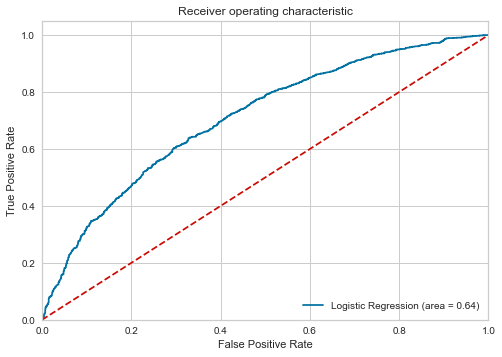

In [223]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_validation, logreg.predict(X_validation_new2))
fpr, tpr, thresholds = roc_curve(Y_validation, logreg.predict_proba(X_validation_new2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [224]:
train_df_n = train_df[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min','Y']] 
validation_df_n = validation_df[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min', 'Y']] 

### PyCaret
It is a Python open source machine learning library designed to make performing standard tasks in a machine learning project easy.

It is a Python version of the Caret machine learning package in R, popular because it allows models to be evaluated, compared, and tuned on a given dataset with just a few lines of code.

In [225]:
# Importing module and initializing setup
from pycaret.classification import *
clf1 = setup(data = train_df_n, target = 'Y', test_data= validation_df_n, preprocess=False)

,Description,Value
0,session_id,1647
1,Target,Y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6215, 13)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,12
8,Transformed Train Set,"(6215, 12)"
9,Transformed Test Set,"(2664, 12)"


In [226]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6821,0.7240,0.8002,0.6897,0.7408,0.3355,0.3419,0.2520
ada,Ada Boost Classifier,0.6594,0.6991,0.7759,0.6739,0.7212,0.2890,0.2939,1.1700
lda,Linear Discriminant Analysis,0.6573,0.6992,0.7733,0.6723,0.7192,0.2849,0.2897,0.0400
ridge,Ridge Classifier,0.6568,0.0000,0.7739,0.6717,0.7191,0.2836,0.2886,0.0320
lr,Logistic Regression,0.6563,0.6991,0.7705,0.6722,0.7179,0.2833,0.2879,1.1870
qda,Quadratic Discriminant Analysis,0.6560,0.6934,0.7418,0.6811,0.7100,0.2891,0.2909,0.0350
rf,Random Forest Classifier,0.6492,0.6920,0.7101,0.6842,0.6965,0.2811,0.2819,0.4870
et,Extra Trees Classifier,0.6391,0.6698,0.6650,0.6885,0.6762,0.2688,0.2693,0.5040
nb,Naive Bayes,0.6352,0.6679,0.7478,0.6574,0.6996,0.2402,0.2436,0.0500
knn,K Neighbors Classifier,0.6274,0.6630,0.7064,0.6609,0.6828,0.2324,0.2333,0.1360


In [227]:
gbc_classifier = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6833,0.7431,0.8215,0.6840,0.7465,0.3339,0.3439
1,0.6527,0.7005,0.7734,0.6675,0.7165,0.2746,0.2796
2,0.6913,0.7350,0.8045,0.6978,0.7474,0.3558,0.3618
3,0.6977,0.7119,0.8215,0.6988,0.7552,0.3669,0.3752
4,0.6768,0.7201,0.7989,0.6845,0.7373,0.3241,0.3306
5,0.7101,0.7389,0.8159,0.7146,0.7619,0.3956,0.4013
6,0.6940,0.7497,0.8272,0.6936,0.7545,0.3568,0.3666
7,0.6602,0.7016,0.7734,0.6757,0.7213,0.2912,0.2956
8,0.6779,0.6936,0.7960,0.6870,0.7375,0.3266,0.3326
9,0.6763,0.7455,0.7699,0.6931,0.7295,0.3294,0.3322


Checking Pycaret results on unprocessed data so as to find out the scope of improvement

In [228]:
train_df_wo_encoding1 = train_df_wo_encoding[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min','Y']] 
validation_df_wo_encoding1= validation_df_wo_encoding[['coupon', 'CoffeeHouse', 'destination', 'expiration', 'Restaurant20To50', 'weather', 'gender', 'passanger', 'Bar','direction_same','occupation','toCoupon_GEQ25min','Y']] 
clf2 = setup(data = train_df_wo_encoding1, target = 'Y', test_data= validation_df_wo_encoding1, preprocess=True, fix_imbalance=True)

,Description,Value
0,session_id,2769
1,Target,Y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6215, 13)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,False


In [229]:
best_model2 = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6787,0.7307,0.7498,0.7038,0.7259,0.3386,0.3399,0.2260
gbc,Gradient Boosting Classifier,0.6769,0.7209,0.7540,0.7000,0.7259,0.3337,0.3354,0.5000
ridge,Ridge Classifier,0.6541,0.0000,0.6653,0.7078,0.6858,0.3018,0.3025,0.1480
lda,Linear Discriminant Analysis,0.6539,0.6992,0.6651,0.7077,0.6857,0.3015,0.3022,0.1660
ada,Ada Boost Classifier,0.6536,0.6977,0.6843,0.6992,0.6916,0.2965,0.2967,0.3110
lr,Logistic Regression,0.6528,0.6991,0.6628,0.7072,0.6842,0.2995,0.3003,0.1950
rf,Random Forest Classifier,0.6521,0.6929,0.7039,0.6900,0.6966,0.2890,0.2894,0.6800
et,Extra Trees Classifier,0.6404,0.6718,0.6574,0.6934,0.6744,0.2733,0.2743,0.6950
svm,SVM - Linear Kernel,0.6401,0.0000,0.6981,0.6855,0.6824,0.2628,0.2726,0.1820
dt,Decision Tree Classifier,0.6241,0.6450,0.6288,0.6837,0.6547,0.2439,0.2451,0.1700


In [230]:
lgbm1 = create_model('lightgbm')
pred_holdout = predict_model(lgbm1)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6865,0.7467,0.7875,0.6985,0.7403,0.3484,0.3524
1,0.6624,0.7119,0.7479,0.6857,0.7154,0.3023,0.3041
2,0.6768,0.7331,0.7479,0.7021,0.7243,0.3349,0.3359
3,0.6849,0.7422,0.7734,0.7018,0.7358,0.3477,0.3502
4,0.6817,0.7277,0.7507,0.7067,0.7280,0.3451,0.3461
5,0.6940,0.7436,0.7450,0.7245,0.7346,0.3736,0.3738
6,0.7005,0.7575,0.7847,0.7158,0.7486,0.3801,0.3825
7,0.6602,0.7104,0.7110,0.6972,0.7041,0.3053,0.3054
8,0.6651,0.7015,0.7252,0.6975,0.7111,0.3130,0.3133
9,0.6747,0.7322,0.7244,0.7083,0.7163,0.3353,0.3354


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6866,0.7386,0.7612,0.7103,0.7348,0.3528,0.3540


In [231]:
import math
print(-(3/5)*math.log((3/5),2)-(2/5)*math.log((2/5),2))
print(-(2/3)*math.log((2/3),2)-(1/3)*math.log((1/3),2))

0.9709505944546686
0.9182958340544896


In [232]:
# sm = SMOTE(random_state=42)
# X_train_noscore, y_train_noscore = sm.fit_resample(X_train_noscore, y_train_noscore)
# y_train_noscore.value_counts()
# # specify configurations as dict
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'num_boost_round':1000,
#     'num_threads':2,
#     'num_class' : 1,
#     'max_bin':200,
#     'num_leaves': 32,
#     'max_depth' : -1,
#     'learning_rate': 0.02,
#     'num_class:':1,
#     }
# gbm = lgbm.LGBMClassifier(params)
# gridParams = {
#     'boosting_type':['dart','gbdt'],
#     'metric':[
#         'binary_logloss',
#         'binary_error',
#         'auc'
#     ],
#     'num_leaves': np.array([8,16,32]),
#     'max_bin':[50,100,200,500],
#     'objective':['binary']
# #     ,'feature_fraction': [0.2, 0.4, 0.6, 0.7, 0.8]
#      ,'reg_lambda': [0.01,10.0]
#      ,'min_data_in_leaf':[0,20]
# }

# grid = GridSearchCV(gbm, gridParams, verbose=2, cv=4, n_jobs=2)
# grid.fit(train_noscore.drop(columns=['active_status']),train_noscore['active_status'])
# run.log_list('grid.best_params_',grid.best_params_)
# run.log('grid.best_score_',grid.best_score_)
# best_params = grid.best_params_
# for i in best_params:
#     print(i)
# lgb_train = lgbm.Dataset(X_train_noscore, y_train_noscore)
# lgb_eval  = lgbm.Dataset(X_test_noscore, y_test_noscore, reference=lgb_train)
# gbm = lgbm.train(best_params,
#             lgb_train,
#             num_boost_round=5000,
#             valid_sets=[lgb_train,lgb_eval],
#             valid_names=['train', 'eval'],
#             learning_rates= lambda iter: 0.008 * (0.99 ** iter),  ## change from 0
#             early_stopping_rounds=10
#                 )
# # -

# gbm.save_model(models +'full_lgbm_opr_no_score_'+'.pkl')
# model = Model.register(model_path=models +'full_lgbm_opr_no_score_'+'.pkl',
#                        model_name="full_lgbm_opr_no_score_2021",
#                        workspace=ws)

In [233]:
# if the dataset is unbalanced i.e no. of values in each level of target variable varies a lot.Then it should be balanced. 
# For this SMOTE is used.
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm= sm.fit_resample(Xtrain_new2, Ytrain)
y_train_sm.value_counts()

1    3529
0    3529
Name: Y, dtype: int64

In [234]:
#Now LGBM model is used to train data. For this parameters are provided for LGBMClassifier function.
import lightgbm as lgbm
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_boost_round':1000,
    'num_threads':2,
    'num_leaves': 32,
    'max_depth' : -1,
    'learning_rate': 0.05,
    'num_class:':1,
    }
gbm = lgbm.LGBMClassifier(params)

In [235]:
# Before training data, Best parameters are found out using GridSearchCV from all alternatives of parameters.
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
gbm1 = lgbm.LGBMClassifier({
    'early_stopping_rounds':100, 'bagging_fraction': 0.5, 'bagging_freq' :5,  'objective':'binary',   'num_boost_round':1000,'num_threads':4,
})
gridParams = {
    'boosting_type':['dart','gbdt'],
    'metric':[
        'binary_logloss',
        'binary_error',
        'auc'
    ],
    'num_leaves': np.array([8,16,32]),
    'learning_rate': [0.05,0.1,0.15, 0.2, 0.25] ,
    'max_depth' : [2,3,4,5] 
}
grid = GridSearchCV(gbm1, gridParams, verbose=2, cv=4, n_jobs=1)
grid.fit(X_train_sm, y_train_sm)

Fitting 4 folds for each of 360 candidates, totalling 1440 fits
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8 
[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8 
[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8 
[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=8, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=16 
[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=16, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=16 
[CV]  boosting_type=dart, learning_rate=0.05, max_depth=2, metric=binary_logloss, num_leaves=16, total=   0.1s
[CV] boosting_type=dart, learning_rate=0.05, max_depth=2, metric=b

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  3.6min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMClassifier(boosting_type={'bagging_fraction': 0.5,
                                                     'bagging_freq': 5,
                                                     'early_stopping_rounds': 100,
                                                     'num_boost_round': 1000,
                                                     'num_threads': 4,
                                                     'objective': 'binary'},
                                      class_weight=None, colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split...
                                      subsample=1.0, subsample_for_bin=200000,
                                      su

In [236]:
#Finding best parameters
best_params = grid.best_params_
print(best_params)


{'boosting_type': 'gbdt', 'learning_rate': 0.25, 'max_depth': 5, 'metric': 'binary_logloss', 'num_leaves': 32}


In [237]:
#Using LGBM Classifier with best parameters and then training the training data
gbm = lgbm.LGBMClassifier(objective='binary',   
                        num_boost_round= 1000,
                        num_threads= 4,
                        boosting_type= 'dart', 
                        learning_rate= 0.25, 
                        max_depth= 5, 
                        metric= 'binary_logloss')
gbm.fit(X_train_sm, y_train_sm,
        early_stopping_rounds= 100,
        eval_set=[(X_train_sm, y_train_sm), (X_validation_new2, Y_validation)])


[1]	training's binary_logloss: 0.655844	valid_1's binary_logloss: 0.66101
[2]	training's binary_logloss: 0.633525	valid_1's binary_logloss: 0.642609
[3]	training's binary_logloss: 0.617839	valid_1's binary_logloss: 0.631559
[4]	training's binary_logloss: 0.607041	valid_1's binary_logloss: 0.62303
[5]	training's binary_logloss: 0.599789	valid_1's binary_logloss: 0.618464
[6]	training's binary_logloss: 0.594317	valid_1's binary_logloss: 0.614479
[7]	training's binary_logloss: 0.58879	valid_1's binary_logloss: 0.612279
[8]	training's binary_logloss: 0.59118	valid_1's binary_logloss: 0.613932
[9]	training's binary_logloss: 0.587053	valid_1's binary_logloss: 0.611252
[10]	training's binary_logloss: 0.583232	valid_1's binary_logloss: 0.609627
[11]	training's binary_logloss: 0.579248	valid_1's binary_logloss: 0.606878
[12]	training's binary_logloss: 0.580322	valid_1's binary_logloss: 0.607481
[13]	training's binary_logloss: 0.576769	valid_1's binary_logloss: 0.605922
[14]	training's binary_lo

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.25, max_depth=5,
               metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=1000, num_leaves=31, num_threads=4,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [238]:
#Predictions using trained data on validation data and output as 1 and 0 is available
y_pred = gbm.predict(X_validation_new2)

In [239]:
#If output is needed in terms of probability
gbm.predict_proba(X_validation_new2)

array([[0.40651888, 0.59348112],
       [0.37296627, 0.62703373],
       [0.70670413, 0.29329587],
       ...,
       [0.193374  , 0.806626  ],
       [0.62355244, 0.37644756],
       [0.45649897, 0.54350103]])

In [240]:
from sklearn.model_selection import cross_val_score
print('Accuracy for Train Set', cross_val_score(gbm, Xtrain_new2, Ytrain, scoring='accuracy', cv=4, n_jobs=4))
print('Accuracy for Validation Set', cross_val_score(gbm, X_validation_new2, Y_validation, scoring='accuracy', cv=4, n_jobs=4))

Accuracy for Train Set [0.67374517 0.66537967 0.67245817 0.65035415]
Accuracy for Validation Set [0.64414414 0.65165165 0.64264264 0.65465465]


In [241]:
print('auc for Train Set', cross_val_score(gbm, Xtrain_new2, Ytrain, scoring='roc_auc', cv=4, n_jobs=4))
print('auc for Validation Set', cross_val_score(gbm, X_validation_new2, Y_validation, scoring='roc_auc', cv=4, n_jobs=4))

auc for Train Set [0.71418903 0.71013778 0.72278237 0.69422394]
auc for Validation Set [0.66490155 0.69748804 0.69557876 0.70889768]


In [242]:
cross_val_score(gbm, X_validation_new2, Y_validation, scoring='accuracy', cv=4, n_jobs=-1)

array([0.64414414, 0.65165165, 0.64264264, 0.65465465])

In [243]:
# lgb_train = lgbm.Dataset(X_train_sm, y_train_sm)
# lgb_eval  = lgbm.Dataset(X_validation_new2, Y_validation, reference=lgb_train)
# gbm = lgbm.train(best_params,
            
#             lgb_train,
#             num_boost_round=5000,
#             valid_sets=[lgb_train,lgb_eval],
#             valid_names=['train', 'eval'],
#             early_stopping_rounds=10,
#                 )

In [244]:
y_pred = gbm.predict(X_validation_new2, raw_score=False)
print(y_pred)

[1 1 0 ... 1 0 1]


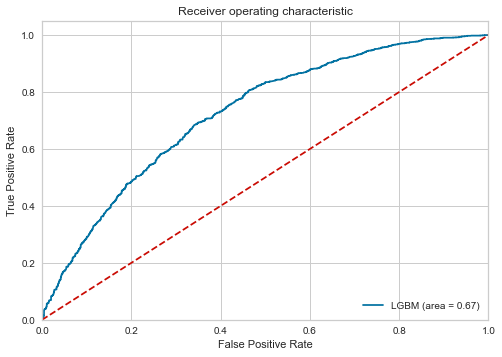

In [245]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_validation, y_pred)
fpr, tpr, thresholds = roc_curve(Y_validation, gbm.predict_proba(X_validation_new2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LGBM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [246]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

yhat = gbm.predict_proba(Xtrain_new2)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(Ytrain, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.414, F-Score=0.81927


In [247]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')


yhat = gbm.predict_proba(X_validation_new2)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(Y_validation, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.250, F-Score=0.75795


In [248]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')


# keep probabilities for the positive outcome only
yhat = gbm.predict_proba(Xtrain_new2)
probs_train = yhat[:, 1]
yhat = gbm.predict_proba(X_validation_new2)
probs_val = yhat[:, 1]
# define thresholds
thresholds = [0.3]
# evaluate each threshold
score_train = [f1_score(Ytrain, to_labels(probs_train, t)) for t in thresholds]
score_val = [f1_score(Y_validation, to_labels(probs_val, t)) for t in thresholds]
# get best threshold
ix = 0
print('Threshold_train=%.3f, F-Score_train=%.5f' % (thresholds[ix], score_train[ix]))
print('Threshold_test=%.3f, F-Score_test=%.5f' % (thresholds[ix], score_val[ix]))


Threshold_train=0.300, F-Score_train=0.80924
Threshold_test=0.300, F-Score_test=0.75266


In [309]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

def MyLGBClassifier(gbm, X, Y, THRESHOLD):
    preds = np.where(gbm.predict_proba(X)[:,1] > THRESHOLD, 1, 0)
    df = pd.DataFrame(data=[accuracy_score(Y, preds), recall_score(Y, preds),
                   precision_score(Y, preds), roc_auc_score(Y, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])
    return df


In [310]:
MyLGBClassifier(gbm, X_validation_new2, Y_validation, 0.3)

,0
accuracy,0.668168
recall,0.884868
precision,0.654820
roc_auc_score,0.632557


In [311]:
MyLGBClassifier(gbm, Xtrain_new2, Ytrain, 0.3)

,0
accuracy,0.746098
recall,0.948427
precision,0.705672
roc_auc_score,0.714348


# Using shap values to interpret the model

In [251]:
import shap

explainer = shap.Explainer(gbm)
shap_values = explainer.shap_values(Xtrain_new2)

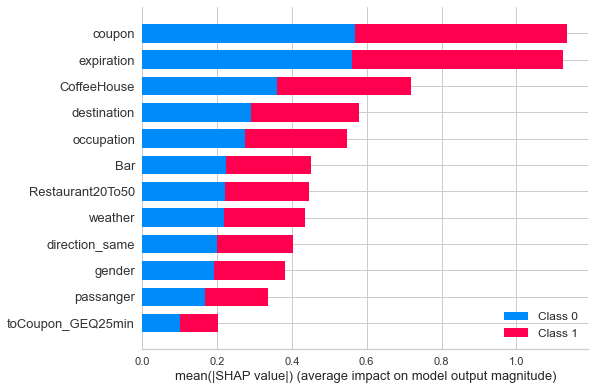

In [252]:
shap.summary_plot(shap_values, Xtrain_new2, plot_type="bar")

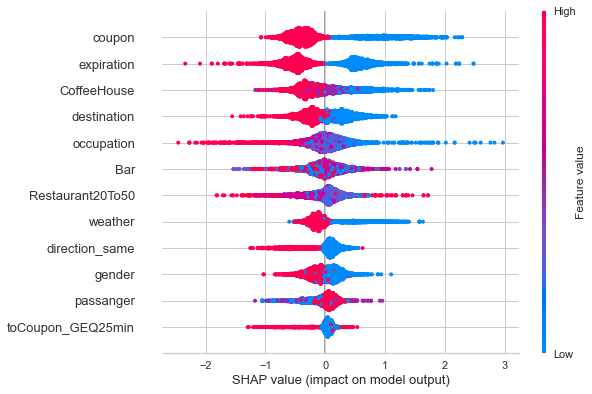

In [300]:
shap_values = explainer.shap_values(Xtrain_new2)
shap.summary_plot(shap_values[0], Xtrain_new2.values, feature_names = Xtrain_new2.columns)

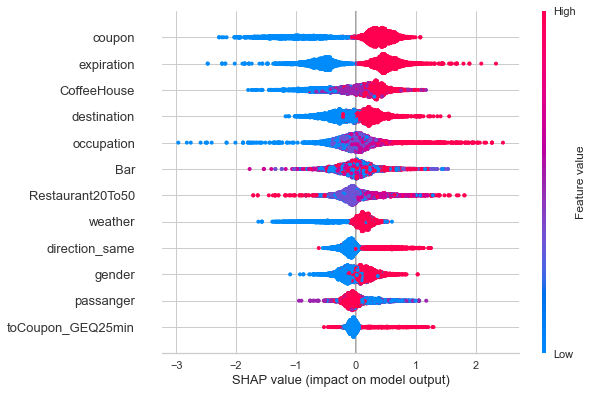

In [301]:
shap.summary_plot(shap_values[1], Xtrain_new2.values, feature_names = Xtrain_new2.columns)

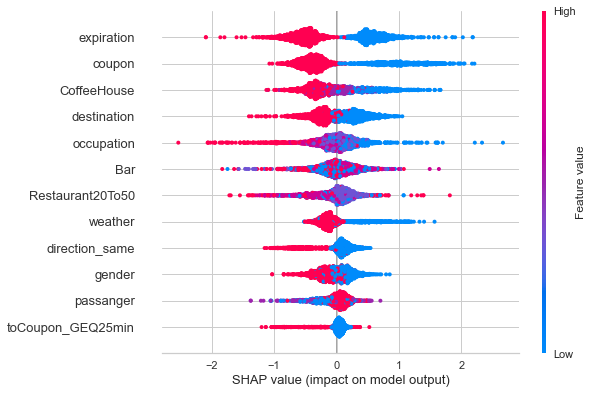

In [302]:
shap_values = explainer.shap_values(X_validation_new2)
shap.summary_plot(shap_values[0], X_validation_new2.values, feature_names = X_validation_new2.columns)

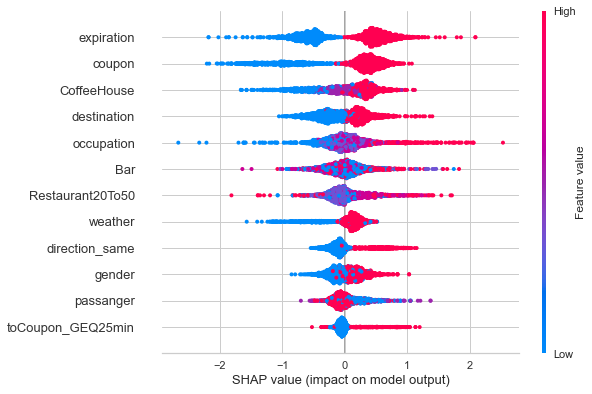

In [303]:
shap.summary_plot(shap_values[1], X_validation_new2.values, feature_names = X_validation_new2.columns)